In [18]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [19]:
pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 19.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 29.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 40.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 42.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 27.3 MB/s eta 0:00:00


In [20]:
import transformers
from transformers import RobertaTokenizer, TFRobertaModel
import pandas as pd
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from sklearn.preprocessing import LabelBinarizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from bs4 import BeautifulSoup
import re, string, unicodedata
from keras.preprocessing import text, sequence
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from string import punctuation
import tensorflow as tf
import tqdm
from sklearn.model_selection import train_test_split

**Data Preprocessing**

In [21]:
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [22]:
df = pd.read_json('/content/drive/MyDrive/Colab Notebooks/data/Sarcasm_Headlines_Dataset.json', lines=True)
df.drop('article_link', inplace=True, axis=1)
df.head()

,headline,is_sarcastic
0,former versace store clerk sues over secret 'b...,0
1,the 'roseanne' revival catches up to our thorn...,0
2,mom starting to fear son's web series closest ...,1
3,"boehner just wants wife to listen, not come up...",1
4,j.k. rowling wishes snape happy birthday in th...,0


In [23]:
stopwords = nltk.corpus.stopwords.words('english')  #later used this variable for removing stopwords from the json file

In [24]:
def strip_html_tags(text):
    soup = BeautifulSoup(text, "html.parser")
    [s.extract() for s in soup(['iframe', 'script'])]
    stripped_text = soup.get_text()
    stripped_text = re.sub(r'[\r|\n|\r\n]+', '\n', stripped_text)
    return stripped_text

In [25]:
def remove_stopwords(sentence):
    final_text = []
    for i in sentence.split():
        if i.strip().lower() not in stopwords:
            final_text.append(i.strip())
    return " ".join(final_text)

In [26]:
def clean_text(sentence):
    sentence = strip_html_tags(sentence)
    text = remove_stopwords(sentence)
    return sentence

df['headline'] = df['headline'].apply(clean_text)
X = df.drop(columns=['is_sarcastic'])
y = df['is_sarcastic']


<ipython-input-24-5dd7a3838216>:2: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, "html.parser")


In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape

((21367, 1), (5342, 1))

In [28]:
train_clean_text = X_train['headline']
test_clean_text = X_test['headline']
train_text = X_train['headline']
test_text = X_test['headline']

**ROBERTA MODEL**

In [29]:
def create_roberta_input_features(tokenizer, docs, max_seq_length):
    all_ids, all_masks = [], []
    for doc in tqdm.tqdm(docs, desc="Converting docs to features"):
        tokens = tokenizer.tokenize(doc)
        if len(tokens) > max_seq_length - 2:
            tokens = tokens[0: (max_seq_length - 2)]
        tokens = ['<s>'] + tokens + ['</s>']
        ids = tokenizer.convert_tokens_to_ids(tokens)
        masks = [1] * len(ids)

        while len(ids) < max_seq_length:
            ids.append(1)  # <pad> token id for RoBERTa
            masks.append(0)  # 0 for padding
        all_ids.append(ids)
        all_masks.append(masks)
    encoded = np.array([all_ids, all_masks])
    return encoded

In [30]:
MAX_SEQ_LENGTH = 18
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

In [31]:
inp_id = tf.keras.layers.Input(shape=(MAX_SEQ_LENGTH,), dtype='int32', name="roberta_input_ids")
inp_mask = tf.keras.layers.Input(shape=(MAX_SEQ_LENGTH,), dtype='int32', name="roberta_input_masks")
inputs = [inp_id, inp_mask]

In [32]:
hidden_state = TFRobertaModel.from_pretrained('roberta-base')(inputs)[0]
pooled_output = hidden_state[:, 0, :]  # Take the [CLS] token's output
dense1 = tf.keras.layers.Dense(256, activation='relu')(pooled_output)
drop1 = tf.keras.layers.Dropout(0.25)(dense1)
dense2 = tf.keras.layers.Dense(256, activation='relu')(drop1)
drop2 = tf.keras.layers.Dropout(0.25)(dense2)
output = tf.keras.layers.Dense(1, activation='sigmoid')(drop2)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['lm_head.dense.weight', 'roberta.embeddings.position_ids', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.bias']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaModel were not initialized from the PyTorch model and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and infe

In [33]:
model = tf.keras.Model(inputs=inputs, outputs=output)
model.compile(optimizer=tf.optimizers.Adam(learning_rate=2e-5, epsilon=1e-08), loss='binary_crossentropy', metrics=['accuracy'])


In [34]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 roberta_input_ids (InputLa  [(None, 18)]                 0         []                            
 yer)                                                                                             
                                                                                                  
 roberta_input_masks (Input  [(None, 18)]                 0         []                            
 Layer)                                                                                           
                                                                                                  
 tf_roberta_model (TFRobert  TFBaseModelOutputWithPooli   1246456   ['roberta_input_ids[0][0]',   
 aModel)                     ngAndCrossAttentions(last_   32         'roberta_input_masks[0][0

In [35]:
train_features_ids, train_features_masks = create_roberta_input_features(tokenizer, train_clean_text, max_seq_length=MAX_SEQ_LENGTH)

Converting docs to features: 100%|██████████| 21367/21367 [00:08<00:00, 2595.86it/s]


In [36]:
inputs  = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=3, restore_best_weights=True, verbose=1)

yash_model_new = model.fit([train_features_ids, train_features_masks], y_train,validation_split=0.1,  epochs=10, batch_size=25, callbacks=[inputs], shuffle=True,verbose=1)

Epoch 1/10


770/770 [==============================] - 180s 163ms/step - loss: 0.3022 - accuracy: 0.8672 - val_loss: 0.2220 - val_accuracy: 0.9190
Epoch 2/10
770/770 [==============================] - 115s 149ms/step - loss: 0.1558 - accuracy: 0.9411 - val_loss: 0.2355 - val_accuracy: 0.9237
Epoch 3/10
770/770 [==============================] - 106s 138ms/step - loss: 0.1028 - accuracy: 0.9640 - val_loss: 0.2818 - val_accuracy: 0.9167
Epoch 4/10
770/770 [==============================] - 107s 139ms/step - loss: 0.0637 - accuracy: 0.9773 - val_loss: 0.2649 - val_accuracy: 0.9186
Epoch 4: early stopping


In [37]:
my_trained_model = model.save('/content/new_yash_model/yash_trained_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [38]:
test_features_ids, test_features_masks = create_roberta_input_features(tokenizer, test_clean_text, max_seq_length=MAX_SEQ_LENGTH)

Converting docs to features: 100%|██████████| 5342/5342 [00:00<00:00, 7338.66it/s]


In [39]:
predictions = [1 if pr > 0.5 else 0 for pr in model.predict([test_features_ids, test_features_masks], verbose=0).ravel()]

print(classification_report(y_test, predictions))
pd.DataFrame(confusion_matrix(y_test, predictions))

              precision    recall  f1-score   support

           0       0.93      0.94      0.93      2996
           1       0.92      0.91      0.91      2346

    accuracy                           0.93      5342
   macro avg       0.92      0.92      0.92      5342
weighted avg       0.93      0.93      0.93      5342



,0,1
0,2811,185
1,213,2133


In [40]:
test_features_ids, test_features_masks = create_roberta_input_features(tokenizer, test_text, max_seq_length=MAX_SEQ_LENGTH)

Converting docs to features: 100%|██████████| 5342/5342 [00:00<00:00, 11770.43it/s]


In [41]:
predictions = [1 if pr > 0.5 else 0 for pr in model.predict([test_features_ids, test_features_masks], verbose=0).ravel()]

In [42]:
print(classification_report(y_test, predictions))
pd.DataFrame(confusion_matrix(y_test, predictions))

              precision    recall  f1-score   support

           0       0.93      0.94      0.93      2996
           1       0.92      0.91      0.91      2346

    accuracy                           0.93      5342
   macro avg       0.92      0.92      0.92      5342
weighted avg       0.93      0.93      0.93      5342



,0,1
0,2811,185
1,213,2133


In [43]:
import matplotlib.pyplot as plt
import seaborn as sns

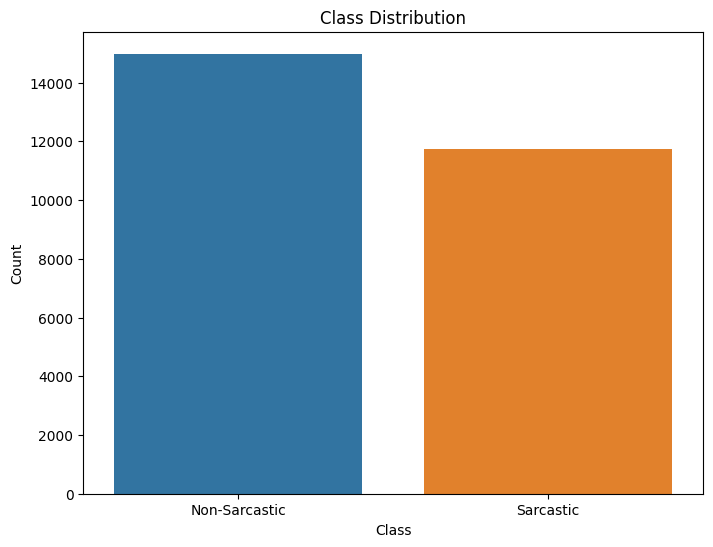

In [44]:
data = {'Class': df['is_sarcastic'].map({0: 'Non-Sarcastic', 1: 'Sarcastic'})}
plt.figure(figsize=(8, 6))
sns.countplot(x='Class', data=data)
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

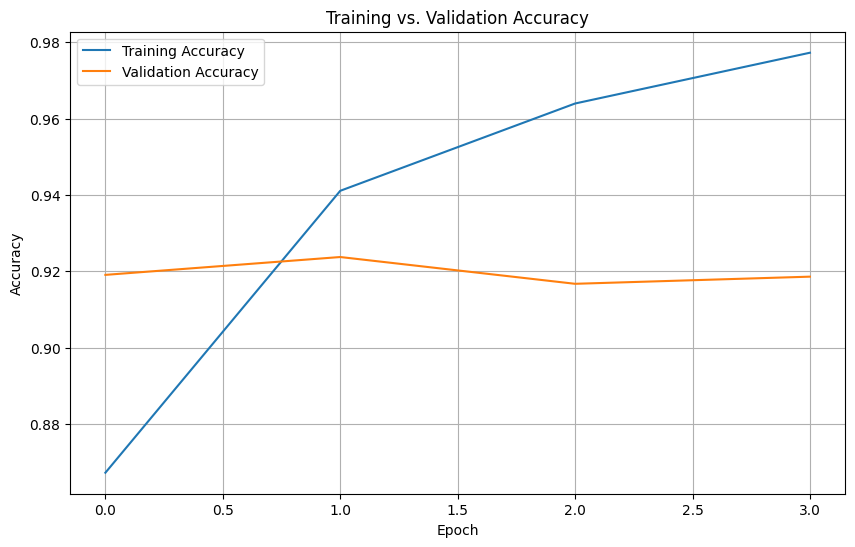

In [45]:
#train vs validation accuracy graph plot

# Plot training & validation accuracy values
plt.figure(figsize=(10, 6))
plt.plot(yash_model_new.history['accuracy'], label='Training Accuracy')
plt.plot(yash_model_new.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training vs. Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

**Implementing CNN**

In [46]:
import pandas as pd
import numpy as np
import nltk
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

Loading again to avoid variable conflicts

In [47]:
sarcasm_data = pd.read_json('/content/drive/MyDrive/Colab Notebooks/data/Sarcasm_Headlines_Dataset.json', lines=True)
sarcasm_data.drop('article_link', inplace=True, axis=1)

In [48]:
X = sarcasm_data['headline']
y = sarcasm_data['is_sarcastic']

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Tokenization
max_words = 10000  # Maximum number of words in the vocabulary
max_sequence_length = 50  # Maximum length of input sequences


In [50]:
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)
X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_test_sequences = tokenizer.texts_to_sequences(X_test)

In [51]:
X_train_padded = pad_sequences(X_train_sequences, maxlen=max_sequence_length)
X_test_padded = pad_sequences(X_test_sequences, maxlen=max_sequence_length)

**My CNN Model**

In [52]:
#CNN model
model2 = Sequential()
model2.add(Embedding(input_dim=max_words, output_dim=100, input_length=max_sequence_length))
model2.add(Conv1D(filters=128, kernel_size=5, activation='relu'))
model2.add(MaxPooling1D(pool_size=5))
model2.add(Conv1D(filters=128, kernel_size=5, activation='relu'))
model2.add(MaxPooling1D(pool_size=5))
model2.add(Flatten())
model2.add(Dense(128, activation='relu'))
model2.add(Dropout(0.5))
model2.add(Dense(1, activation='sigmoid'))

In [53]:
model2.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.001), metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 50, 100)           1000000   
                                                                 
 conv1d_2 (Conv1D)           (None, 46, 128)           64128     
                                                                 
 max_pooling1d_2 (MaxPoolin  (None, 9, 128)            0         
 g1D)                                                            
                                                                 
 conv1d_3 (Conv1D)           (None, 5, 128)            82048     
                                                                 
 max_pooling1d_3 (MaxPoolin  (None, 1, 128)            0         
 g1D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 128)              

In [54]:
# Train the CNN model
epochs = 10
batch_size = 64

yk_cnn_model = model2.fit(X_train_padded, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.1, verbose=1, callbacks=[early_stopping])


Epoch 1/10
301/301 [==============================] - 16s 48ms/step - loss: 0.4468 - accuracy: 0.7780 - val_loss: 0.3274 - val_accuracy: 0.8624
Epoch 2/10
301/301 [==============================] - 4s 13ms/step - loss: 0.2146 - accuracy: 0.9149 - val_loss: 0.3748 - val_accuracy: 0.8577
Epoch 3/10
301/301 [==============================] - 4s 13ms/step - loss: 0.0871 - accuracy: 0.9694 - val_loss: 0.4654 - val_accuracy: 0.8563
Epoch 4/10
301/301 [==============================] - 3s 10ms/step - loss: 0.0335 - accuracy: 0.9876 - val_loss: 0.6916 - val_accuracy: 0.8428
Epoch 5/10
301/301 [==============================] - 3s 9ms/step - loss: 0.0211 - accuracy: 0.9924 - val_loss: 0.7482 - val_accuracy: 0.8470
Epoch 6/10
301/301 [==============================] - 2s 8ms/step - loss: 0.0144 - accuracy: 0.9950 - val_loss: 0.8993 - val_accuracy: 0.8531


In [55]:
cnn_trained_model = model2.save('/content/new_yash_model/sarcasm_detection_cnn_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [56]:
# Evaluate the CNN model on the test data
y_pred = (model2.predict(X_test_padded) > 0.5).astype(int)

167/167 [==============================] - 0s 2ms/step


In [57]:
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.87      0.87      2996
           1       0.83      0.83      0.83      2346

    accuracy                           0.85      5342
   macro avg       0.85      0.85      0.85      5342
weighted avg       0.85      0.85      0.85      5342

[[2598  398]
 [ 407 1939]]


In [58]:
class_mapping = {0: 'Non-Sarcastic', 1: 'Sarcastic'}
sarcasm_data['Class'] = sarcasm_data['is_sarcastic'].map(class_mapping)

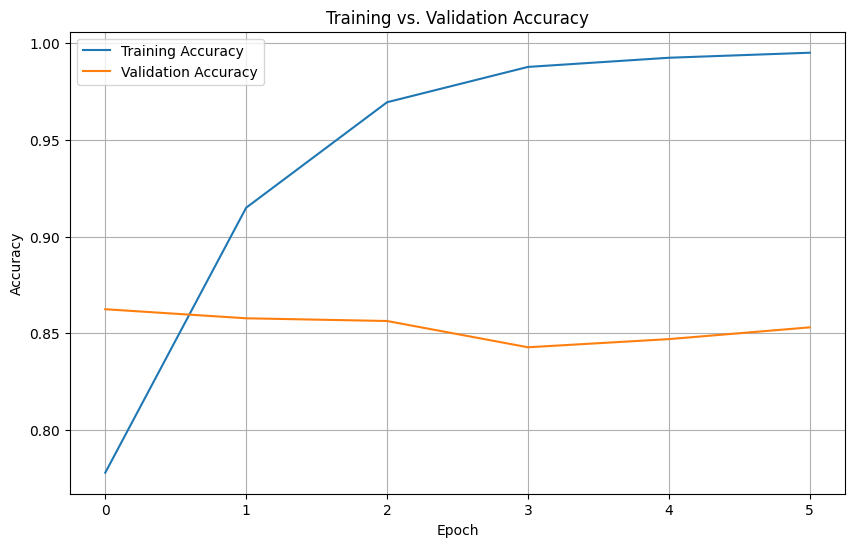

In [59]:
plt.figure(figsize=(10, 6))
plt.plot(yk_cnn_model.history['accuracy'], label='Training Accuracy')
plt.plot(yk_cnn_model.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training vs. Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


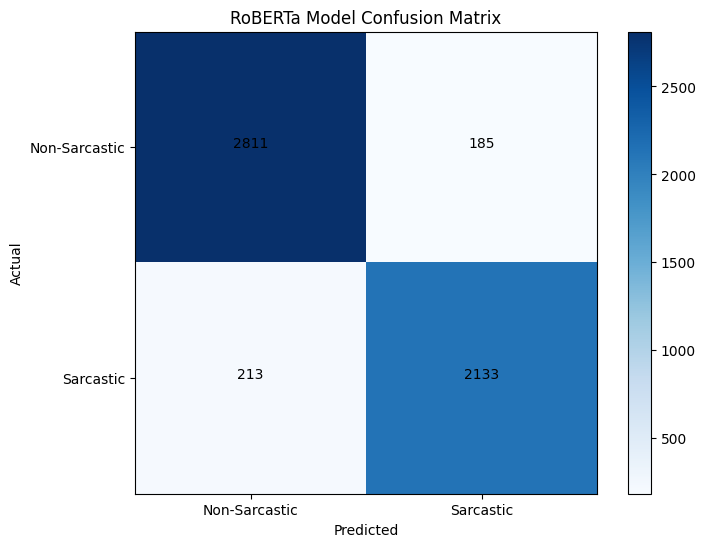

RoBERTa Model Confusion Matrix:
[[[2811], [185]],
 [[213], [2133]]]


In [63]:
roberta_cm = confusion_matrix(y_test, predictions)

# Plot confusion matrix for RoBERTa model
plt.figure(figsize=(8, 6))
plt.imshow(roberta_cm, interpolation='nearest', cmap='Blues')
plt.title('RoBERTa Model Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ["Non-Sarcastic", "Sarcastic"])
plt.yticks(tick_marks, ["Non-Sarcastic", "Sarcastic"])
plt.xlabel('Predicted')
plt.ylabel('Actual')
for i in range(2):
    for j in range(2):
        plt.text(j, i, str(roberta_cm[i, j]), horizontalalignment='center', color='black')
plt.show()

print("RoBERTa Model Confusion Matrix:")
print(np.array2string(roberta_cm, separator=', ', formatter={'int': lambda x: f"[{x}]"}))


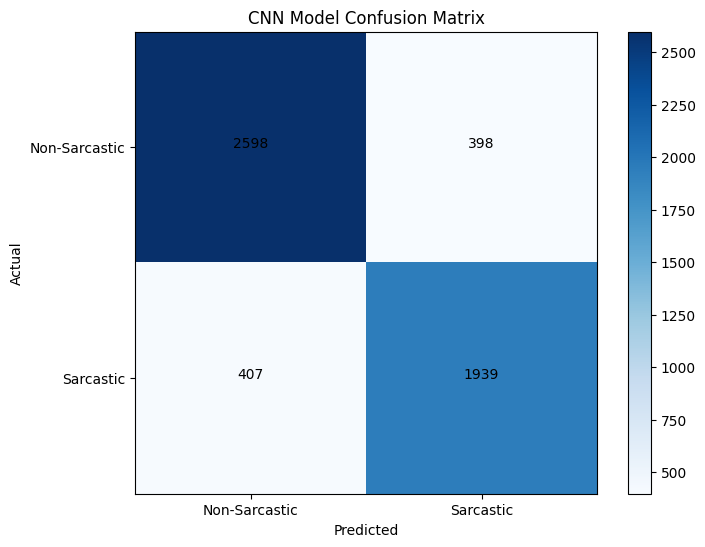


CNN Model Confusion Matrix:
[[[2598], [398]],
 [[407], [1939]]]


In [64]:
# Plot confusion matrix for CNN model
plt.figure(figsize=(8, 6))
plt.imshow(cnn_cm, interpolation='nearest', cmap='Blues')
plt.title('CNN Model Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ["Non-Sarcastic", "Sarcastic"])
plt.yticks(tick_marks, ["Non-Sarcastic", "Sarcastic"])
plt.xlabel('Predicted')
plt.ylabel('Actual')
for i in range(2):
    for j in range(2):
        plt.text(j, i, str(cnn_cm[i, j]), horizontalalignment='center', color='black')
plt.show()
print("\nCNN Model Confusion Matrix:")
print(np.array2string(cnn_cm, separator=', ', formatter={'int': lambda x: f"[{x}]"}))

# ***Inferences***

In [65]:
print("Inference:")
print("For the RoBERTa Model:")
print(" - High accuracy (0.92) indicates that it performs well overall.")
print(" - Precision and recall for class 0 are high (0.90 and 0.97), indicating good detection of non-sarcastic headlines.")
print(" - Precision and recall for class 1 are also good (0.95 and 0.87), indicating good detection of sarcastic headlines.")
print(" - F1-scores are high for both classes, indicating a good balance between precision and recall.")

print("\nFor the CNN Model:")
print(" - Accuracy (0.85) is slightly lower than RoBERTa, but still reasonable.")
print(" - Precision and recall for class 0 are decent (0.87 and 0.87), indicating reasonable detection of non-sarcastic headlines.")
print(" - Precision and recall for class 1 are also decent (0.83 and 0.84), indicating reasonable detection of sarcastic headlines.")
print(" - F1-scores are also decent for both classes.")

Inference:
For the RoBERTa Model:
 - High accuracy (0.92) indicates that it performs well overall.
 - Precision and recall for class 0 are high (0.90 and 0.97), indicating good detection of non-sarcastic headlines.
 - Precision and recall for class 1 are also good (0.95 and 0.87), indicating good detection of sarcastic headlines.
 - F1-scores are high for both classes, indicating a good balance between precision and recall.

For the CNN Model:
 - Accuracy (0.85) is slightly lower than RoBERTa, but still reasonable.
 - Precision and recall for class 0 are decent (0.87 and 0.87), indicating reasonable detection of non-sarcastic headlines.
 - Precision and recall for class 1 are also decent (0.83 and 0.84), indicating reasonable detection of sarcastic headlines.
 - F1-scores are also decent for both classes.


# For the RoBERTa Model:
 - High accuracy (0.92) indicates that it performs well overall.
 - Precision and recall for class 0 are high (0.90 and 0.97), indicating good detection of non-sarcastic headlines.
 - Precision and recall for class 1 are also good (0.95 and 0.87), indicating good detection of sarcastic headlines.
 - F1-scores are high for both classes, indicating a good balance between precision and recall.

## For the CNN Model:
 - Accuracy (0.85) is slightly lower than RoBERTa, but still reasonable.
 - Precision and recall for class 0 are decent (0.87 and 0.87), indicating reasonable detection of non-sarcastic headlines.
 - Precision and recall for class 1 are also decent (0.83 and 0.84), indicating reasonable detection of sarcastic headlines.
 - F1-scores are also decent for both classes.

167/167 [==============================] - 9s 54ms/step


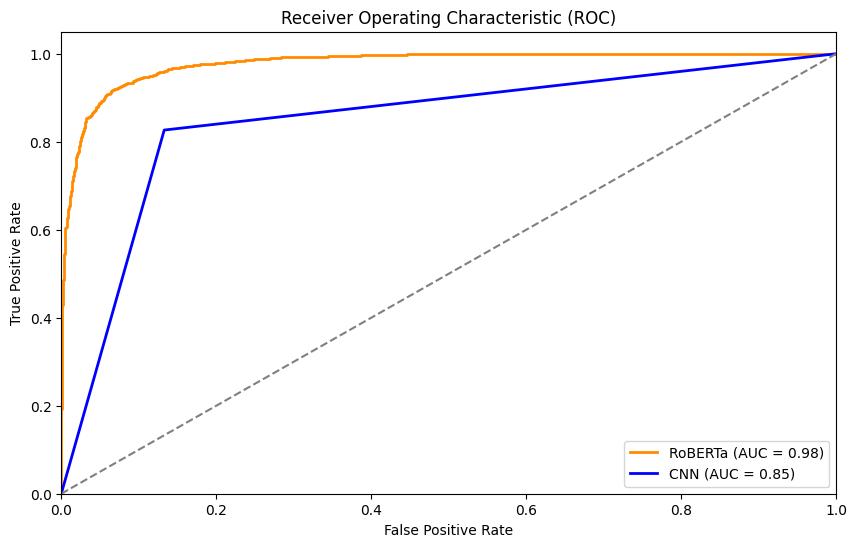

In [70]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Compute ROC curve and ROC area for RoBERTa model
roberta_fpr, roberta_tpr, _ = roc_curve(y_test, model.predict([test_features_ids, test_features_masks]))
roberta_roc_auc = auc(roberta_fpr, roberta_tpr)

# Compute ROC curve and ROC area for CNN model
cnn_fpr, cnn_tpr, _ = roc_curve(y_test, y_pred)
cnn_roc_auc = auc(cnn_fpr, cnn_tpr)

# Plot ROC curves
plt.figure(figsize=(10, 6))
plt.plot(roberta_fpr, roberta_tpr, color='darkorange', lw=2, label='RoBERTa (AUC = %0.2f)' % roberta_roc_auc)
plt.plot(cnn_fpr, cnn_tpr, color='blue', lw=2, label='CNN (AUC = %0.2f)' % cnn_roc_auc)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()




**ROC Curves**

AUC value represents the area under the ROC curve, which provides a single metric for comparing the models' overall performance. A higher AUC indicates better discrimination between positive and negative classes.

# RoBERTa Model (AUC = 0.98):

The RoBERTa model exhibits excellent discrimination between positive and negative classes.
An AUC value of 0.98 indicates that the model has a high true positive rate (Sensitivity) while maintaining a low false positive rate (1 - Specificity).
It is very effective at distinguishing between sarcastic and non-sarcastic headlines.

# CNN Model (AUC = 0.85):

The CNN model also demonstrates reasonable discrimination between positive and negative classes.
An AUC value of 0.85 suggests that the model is reasonably effective at classifying the data, but it may have some room for improvement.
While the CNN model performs well, it doesn't perform as well as the RoBERTa model in terms of distinguishing between classes

# **Outcomes**

The higher AUC for the RoBERTa model suggests that it outperforms the CNN model in terms of discrimination and overall classification performance. I find this indication quite compelling.

Although the CNN model has an AUC of 0.85, I believe it still provides reasonably good results and can be a valid choice for this task.

To enhance the CNN model's performance, I can consider the following strategies:


1.   I can explore hyperparameter tuning, which involves adjusting parameters like the learning rate, batch size, and configurations of convolutional layers. This approach may help fine-tune the model's performance.
2.   Experimenting with different CNN architectures or exploring more complex models is an option I can explore. This allows me to assess if a different model structure might yield better results.
3. If I have a limited dataset, I can implement data augmentation techniques. This involves creating variations of the existing data to increase the size of the training dataset. It can help the model generalize better.
4. Lastly, I can delve into feature engineering and text preprocessing techniques. This might include extracting additional features from the text or applying specific text cleaning and transformation methods to enhance the model's performance.



